In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compile time = 8.415 ms
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info  

In [2]:
%load_ext pyinstrument

In [3]:
# %matplotlib widget
import pack_ga3 as pack_ga2
import pack_runner
importlib.reload(pack_ga2)
fastMode = False
kgs.debugging_mode = 2 if fastMode else 1

tmp = pack_ga2.GA()

# runner = pack_ga2.Orchestrator(n_generations=3 if not fastMode else 50)
# runner.ga = pack_ga2.GAMultiRing(N=16 if not fastMode else 4)
# runner.ga.diversity_reset_threshold = 5./40
# runner.ga.mate_distance=6

# ga_base = pack_ga2.GASinglePopulationOld(N_trees_to_do=40)
# #ga_base.population_size = 250
# #ga_base.prob_mate_own = 0.25
# value = 0.125
# ga_base.population_size = int(ga_base.population_size * value)
# ga_base.selection_size = [int( (s-1) * value)+1 for s in ga_base.selection_size]
# seen = set()
# unique_selection = []
# for s in ga_base.selection_size:
#     while s in seen:
#         s += 1
#     seen.add(s)
#     unique_selection.append(s)
# ga_base.selection_size = unique_selection
# ga_base.selection_size = ga_base.selection_size[:-6]
# print(ga_base.selection_size)
# ga_base.do_legalize = False
# ga_base.reset_check_generations = 50 if not fastMode else 3
# ga_base.reset_check_threshold = 0.5 if not fastMode else 0.9
# ga_base.freeze_duration = 100 if not fastMode else 3
# #ga_base.move.moves[-1][2] *= 2
# ga_base.prob_mate_own = 0.7
# ga_base.reduce_h_threshold = 1e-5/40
# ga_base.always_allow_mate_with_better = False
# ga_base.fixed_h = -1.

# runner.ga.ga_base = ga_base
# runner.ga.do_legalize = False
# runner.ga.allow_reset_ratio = 0.5 if not fastMode else 0.
# runner.ga.make_own_fig = (2,3)
# runner.ga.make_own_fig_size = (18,12)
# runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)) ,(1,True,(1,0)))
# runner.ga.plot_subpopulation_costs_per_generation_ax = ( (0,False,(0,1)) ,(1,True,(1,1)))
# runner.ga.champion_phenotype_ax = (0,2)
# runner.ga.plot_diversity_ax = (1,2)
# runner.diagnostic_plot = False
# runner.seed = 0

runner_one_nTree = pack_ga2.baseline()
runner_one_nTree.ga.do_legalize = False
runner = copy.deepcopy(runner_one_nTree)

ga_list = []
N_trees_list = [156]
for N_tree in N_trees_list:
    ga_list.append( copy.deepcopy(runner_one_nTree.ga) )
    ga_list[-1].ga_base.N_trees_to_do = N_tree
    ga_list[-1].do_legalize= False
    ga_list[-1].N = 4
    ga_list[-1].ga_base.lap_config.algorithm='min_cost_col'
runner.ga = pack_ga2.GAMulti(single_champion=False)
runner.ga.ga_list = ga_list
runner.ga.make_own_fig = (1,1)
runner.ga.make_own_fig_size = (8,8)
runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)),)
runner.diagnostic_plot = False
runner.plot_every = 3
runner.n_generations = 1 if not fastMode else 3
runner.filename = 'matching_test'

runner.seed=84
runner.save_every = 1
runner.run() #warmup

import lap_batch

[ 10  11  13  15  17  20  23  27  31  36  42  49  56  65  76  87 101 117
 135 156 181 209 242 280 323 374 432 500]
[np.int64(10), np.int64(11), np.int64(13), np.int64(15), np.int64(17), np.int64(20), np.int64(23), np.int64(27), np.int64(31), np.int64(36), np.int64(42), np.int64(49), np.int64(56), np.int64(65), np.int64(76), np.int64(87), np.int64(101), np.int64(117), np.int64(135), np.int64(156), np.int64(181), np.int64(209), np.int64(242), np.int64(280), np.int64(323), np.int64(374), np.int64(432), np.int64(500)]
[1, 2, 3, 4, 5, 6, 7, 8, 9, np.int64(10), np.int64(11), np.int64(13), np.int64(15), np.int64(17), np.int64(20), np.int64(23), np.int64(27), np.int64(31), np.int64(36), np.int64(42), np.int64(49), np.int64(56), np.int64(65), np.int64(76), np.int64(87), np.int64(101), np.int64(117), np.int64(135), np.int64(156), np.int64(181), np.int64(209), np.int64(242), np.int64(280), np.int64(323), np.int64(374), np.int64(432), np.int64(500)]
[ 10  11  13  15  17  20  23  27  31  36  42  49

/mnt/d/packing/code/analysis/../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


Generation 0: Best costs = [[0.339005, 2.204733]]


In [4]:
runner = kgs.dill_load(kgs.temp_dir + runner.filename + '.pickle')
runner.n_generations = 3

Processing class: BaseClass
  Added method: BaseClass.__init__
  Added method: BaseClass._check_constraints
  Added method: BaseClass._check_types
  Added method: BaseClass.check_constraints
Processing class: SolutionCollection
  Added method: SolutionCollection.__init__
  Added method: SolutionCollection._check_constraints
  Added method: SolutionCollection._check_types
  Added method: SolutionCollection.check_constraints
  Added method: SolutionCollection.create_clone
  Added method: SolutionCollection.create_clone_batch
  Added method: SolutionCollection.create_empty
  Added method: SolutionCollection.get_crystal_axes
  Added method: SolutionCollection.get_crystal_axes_allocate
  Added method: SolutionCollection.merge
  Added method: SolutionCollection.rotate
  Added method: SolutionCollection.select_ids
Processing class: SolutionCollectionLattice
  Added method: SolutionCollectionLattice.__init__
  Added method: SolutionCollectionLattice._check_constraints
  Added method: SolutionC

/mnt/d/packing/code/analysis/../core/kaggle_support.py:232: UserWarning: Adding a function with a `.__wrapped__` attribute. You may want to profile the wrapped function by adding `snap.__wrapped__` instead.
  module_profiler.add_function(method)


Generation 1: Best costs = [[0.339005, 1.045106]]
Generation 2: Best costs = [[0.339005, 0.693514]]


_     ._   __/__   _ _  _  _ _/_   Recorded: 11:22:53  Samples:  7380
 /_//_/// /_\ / //_// / //_'/ //     Duration: 20.006    CPU time: 19.670
/   _/                      v5.1.1

Cell [6]

20.006 <module>  /tmp/ipykernel_28023/3731672545.py:1
`- 19.992 Orchestrator.run  pack_ga3.py:1324
   |- 9.865 Orchestrator._relax  pack_ga3.py:1280
   |  `- 9.769 run_simulation_list  pack_dynamics.py:633
   |     `- 9.765 OptimizerBFGS.run_simulation  pack_dynamics.py:42
   |        `- 9.758 lbfgs  lbfgs_torch_parallel.py:382
   |           |- 7.839 f_torch  pack_dynamics.py:68
   |           |  |- 7.540 Device.synchronize  <built-in>
   |           |  `- 0.204 CostCompound.compute_cost  pack_cost.py:50
   |           `- 1.675 [self]  lbfgs_torch_parallel.py
   |- 7.790 GAMulti.apply_selection  pack_ga3.py:371
   |  `- 7.790 GAMulti._apply_selection  pack_ga3.py:550
   |     `- 7.790 GAMultiRing.apply_selection  pack_ga3.py:371
   |        `- 7.790 GAMultiRing._apply_selection  pack_ga3.py:550
   |           `- 7.790 GASinglePopulationOld.apply_selection  pack_ga3.py:371
   |              `- 7.790 GASinglePopulationOld._apply_selection  pack_ga3.py:1000
   |                 |- 6.041 compute_genetic_diversity  kaggle_support.py:1212
   |                 |  `- 6.039 compute_genetic_diversity_matrix  kaggle_support.py:1071
   |                 |     `- 6.039 compute_genetic_diversity_matrix_shortcut  kaggle_support.py:959
   |                 |        |- 5.541 Device.synchronize  <built-in>
   |                 |        `- 0.455 [self]  kaggle_support.py
   |                 `- 1.729 compute_genetic_diversity_matrix  kaggle_support.py:1071
   |                    `- 1.729 compute_genetic_diversity_matrix_shortcut  kaggle_support.py:959
   |                       `- 1.724 Device.synchronize  <built-in>
   |- 1.726 Orchestrator._save_checkpoint  pack_ga3.py:1313
   |  `- 1.701 dill_save  kaggle_support.py:166
   |     `- 1.692 dump  dill/_dill.py:250
   |           [50 frames hidden]  dill, pickle
   |              1.458 Pickler.save  pickle.py:532
   |              `- 0.899 GASinglePopulationOld.__getstate__  pack_ga3.py:1182
   |                 `- 0.885 _encode_int8_array  pack_ga3.py:49
   |                    `- 0.728 compress  <built-in>
   `- 0.488 GAMulti.generate_offspring  pack_ga3.py:330
      `- 0.488 GAMulti._generate_offspring  pack_ga3.py:540
         `- 0.488 GAMultiRing.generate_offspring  pack_ga3.py:330
            `- 0.488 GAMultiRing._generate_offspring  pack_ga3.py:619
               `- 0.485 GASinglePopulationOld.generate_offspring  pack_ga3.py:330
                  `- 0.470 GASinglePopulationOld._generate_offspring  pack_ga3.py:1114
                     `- 0.447 MoveSelector.do_move_vec  pack_move.py:42
                        `- 0.446 MoveSelector._do_move_vec  pack_move.py:83
                           `- 0.332 Crossover.do_move_vec  pack_move.py:42
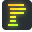

In [5]:
%%pyinstrument
kgs.profiling=True
kgs.enable_module_profiling(kgs)
#kgs.enable_module_profiling(lap_batch)
runner.run()

In [6]:
kgs.print_module_profile()

Timer unit: 1e-09 s

Total time: 0 s
File: /home/jcottaar/miniconda3/envs/rapids-25.10/lib/python3.13/site-packages/decorator.py
Function: decorate.<locals>.fun at line 232

Line #      Hits         Time  Per Hit   % Time  Line Contents
   232                                                   def fun(*args, **kw):
   233                                                       if not kwsyntax:
   234                                                           args, kw = fix(args, kw, sig)
   235                                                       return caller(func, *(extras + args), **kw)

Total time: 0 s
File: /mnt/d/packing/code/analysis/../core/kaggle_support.py
Function: assert_mps at line 43

Line #      Hits         Time  Per Hit   % Time  Line Contents
    43                                           def assert_mps():
    44                                               import subprocess
    45                                               out = subprocess.run(
    46             

In [7]:
print(runner.ga.ga_list[0].ga_list[1].lap_config)

LAPConfig(algorithm='min_cost_col', auction_epsilon_init=0.1, auction_epsilon_final=0.001, auction_epsilon_decay=0.8, auction_max_rounds=1, auction_max_iters=0)
